In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import os
import datetime
import geopandas as gpd
import rasterio
from rasterio.features import geometry_mask
import time
import seaborn as sns
%run ../Functions.ipynb

<>:31: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_153764/2858539060.py:31: SyntaxWarning: invalid escape sequence '\c'
  text = f'$y = {m:.2f} \cdot x + {b:.2f}$'


In [2]:
folder= r'./data/ERA5-RET_MCM500'
fhs = glob.glob(os.path.join(folder,'*.nc'))
dts = xr.open_mfdataset(fhs)
selected_grids =[    
    [-2.5,2.5,17.5,22.5], # sahara
    [37.5,42.5,7.5,12.5], # mountain    
    [7.5,12.5,-2.5,2.5], # coast
    [25,30,-2.5,2.5], #Congo    
]


# MCM percentile map and timeseries

In [6]:
dts_sel=dts.sel(time=slice('2018-01-01','2018-12-31'))
year_sum=dts_sel.sum(dim='time',skipna=False).compute()
year_sum['norm_std'] = year_sum['std']/year_sum['mean']
year_sum['norm_std'].compute()

<xarray.DataArray 'norm_std' (latitude: 161, longitude: 181)> Size: 233kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * longitude  (longitude) float32 724B -30.0 -29.5 -29.0 ... 59.0 59.5 60.0
  * latitude   (latitude) float32 644B 40.0 39.5 39.0 38.5 ... -39.0 -39.5 -40.0

In [ ]:
def get_ts_bbox(dts,bbox):
    [xmin, xmax, ymin, ymax]=bbox
    sel_da=dts.sel(longitude=slice(xmin, xmax), latitude=slice(ymax, ymin))
    ts=sel_da.mean(dim=['longitude','latitude']).compute()
    return ts

for i,bbox in enumerate(selected_grids):
    ts = get_ts_bbox(dts,bbox)
    df=ts.to_dataframe()
    df.to_csv(f'./data/ts_RET_stats_area{i}.csv')

<>:63: SyntaxWarning: invalid escape sequence '\s'
<>:64: SyntaxWarning: invalid escape sequence '\s'
<>:63: SyntaxWarning: invalid escape sequence '\s'
<>:64: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_153764/1197879139.py:63: SyntaxWarning: invalid escape sequence '\s'
  plot_map(ax5,year_sum['std'],unit='$\sigma$ [mm year$^{-1}$]', axtitle='RET standard deviation')
/tmp/ipykernel_153764/1197879139.py:64: SyntaxWarning: invalid escape sequence '\s'
  plot_map(ax6,year_sum['norm_std'],unit='$\sigma_{norm}$ [-]', axtitle='RET normalized standard deviation')
/tmp/ipykernel_153764/1197879139.py:101: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


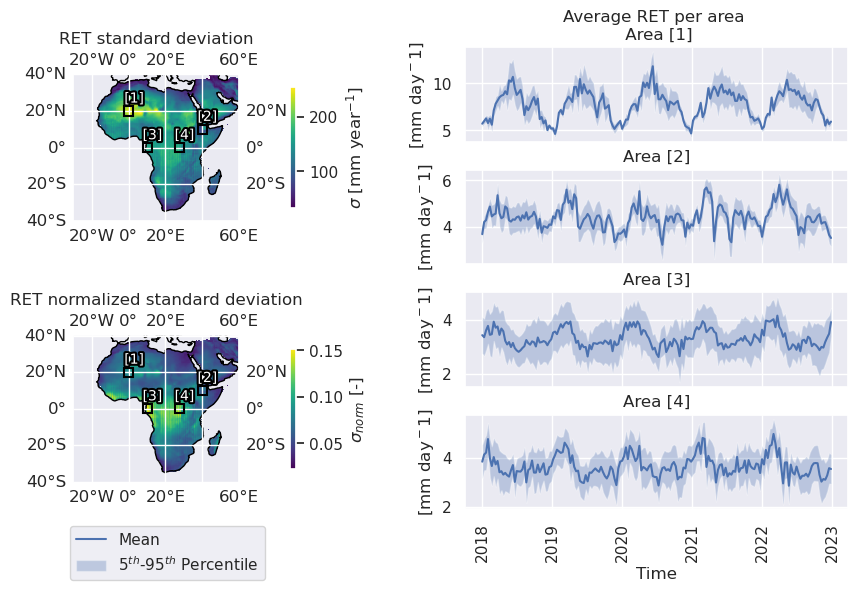

In [11]:
def plot_ts_p95(df,time_scale='1D',ax=None,
               yunit='',axtitle=''):
    '''
    time_scale: '1D', '10D', '1M'
    '''
    sns.set_theme(style="darkgrid")
    # average 5-mean-95 time-series of bbox
    if time_scale != '1D': #'1M' '1D'
        # Resample
        p5_re = df['p5'].resample(time_scale).mean()
        mean_re = df['mean'].resample(time_scale).mean()
        p95_re = df['p95'].resample(time_scale).mean()
    else:
        p5_re = df['p5']
        mean_re = df['mean']
        p95_re = df['p95']
    if ax is None:
        fig,ax=plt.subplots(figsize=(7, 3))
    ax.plot(mean_re.index, mean_re, label='Mean' )
    ax.fill_between(mean_re.index, p5_re, p95_re, alpha=0.3, 
                    label='5$^{th}$-95$^{th}$ Percentile')
    ax.set_ylabel(yunit)
    ax.set_title(axtitle) 

def plot_map(ax,data,unit,axtitle=None):
    mesh = data.plot(ax=ax,transform=ccrs.PlateCarree(), 
                                     cmap='viridis',add_colorbar=False)
    cbar = plt.colorbar(mesh, ax=ax, shrink=0.6,pad=0.2)
    cbar.set_label(unit)
    # Add coastlines and gridlines for context
    ax.coastlines()
    # ax.add_feature(cfeature.BORDERS)
    ax.gridlines(draw_labels=True,zorder=1) 
    ax.set_title(axtitle)
    
# Close any existing plots
plt.close('all')

# Create the figure
fig = plt.figure(figsize=(10,6))

# Create the 4 axes on the right (2x1)
ax1 = plt.subplot(4,2,2)  
ax2 = plt.subplot(4,2,4)  
ax3 = plt.subplot(4,2,6)  
ax4 = plt.subplot(4,2,8) 

# Create the 2 axes on the right (2x1 grid)
ax5 = fig.add_subplot(2, 3, 1, projection=ccrs.PlateCarree())  # 2 rows, 2 columns, position 2
ax6 = fig.add_subplot(2, 3, 4, projection=ccrs.PlateCarree())  # 2 rows, 2 columns, position 4

# Apply the plot functions to each axis
axs_left=[ax1,ax2,ax3,ax4]
for i,bbox in enumerate(selected_grids):
    df= pd.read_csv(f'./data/ts_RET_stats_area{i}.csv',index_col=0,parse_dates=True)
    if i == 0:
        plot_ts_p95(df,time_scale='10D',ax=axs_left[i],
               yunit='[mm day$^-1$]',axtitle=f'Average RET per area \n Area [{i+1}]')
    else:
        plot_ts_p95(df,time_scale='10D',ax=axs_left[i],
               yunit='[mm day$^-1$]',axtitle=f'Area [{i+1}]')

plot_map(ax5,year_sum['std'],unit='$\sigma$ [mm year$^{-1}$]', axtitle='RET standard deviation')
plot_map(ax6,year_sum['norm_std'],unit='$\sigma_{norm}$ [-]', axtitle='RET normalized standard deviation')

# add annotation
# Loop through the selected grids and plot them
def add_bbox(ax):
    for i, grid in enumerate(selected_grids):
        min_lon, max_lon, min_lat, max_lat = grid
        # Plot the rectangle for the selected area
        rect = plt.Rectangle((min_lon, min_lat), max_lon - min_lon, max_lat - min_lat,
                             linewidth=1.5, edgecolor='black', facecolor='none', 
                             transform=ccrs.PlateCarree(),
                            zorder=3)
        ax.add_patch(rect)
        
        # Add text annotation with the index number
        text=ax.text(min_lon, max_lat+0.5, f'[{i+1}]', 
                 horizontalalignment='left', verticalalignment='bottom',
                 color='white', fontsize=10, zorder=4,
                 transform=ccrs.PlateCarree())
        text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='black'),
                           path_effects.Normal()])
add_bbox(ax5)
add_bbox(ax6)

## clean up figure
ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax3.set_xticklabels([])
ax4.set_xlabel('Time')
ax4.legend(loc='upper left', bbox_to_anchor=(-1.05, -0.1))
ax4.tick_params(axis='x', labelrotation=90)
ax5.tick_params(labeltop=False, labelright=False)
# ax5.set_title('Annual normalized standard deviation of RET')
# ax6.set_title('Annual standard deviation of RET')


# Adjust layout to prevent overlap
plt.tight_layout()
plt.subplots_adjust(hspace=0.3,wspace=0.02)
# Show the plot
# plt.suptitle('Average Reference Evapotranspiration')
plt.savefig('./figures/sigma_and_ts.png',bbox_inches='tight')
plt.show()
